In [1]:
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 7777

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=200, noise=.1, random_state=7777)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7777)

feature_dimentions = X[0].shape[0]
print(feature_dimentions)

2


/var/folders/66/zfqvd37j62d2w4m8k583sfcw0000gn/T/ipykernel_90076/3455702804.py:10: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


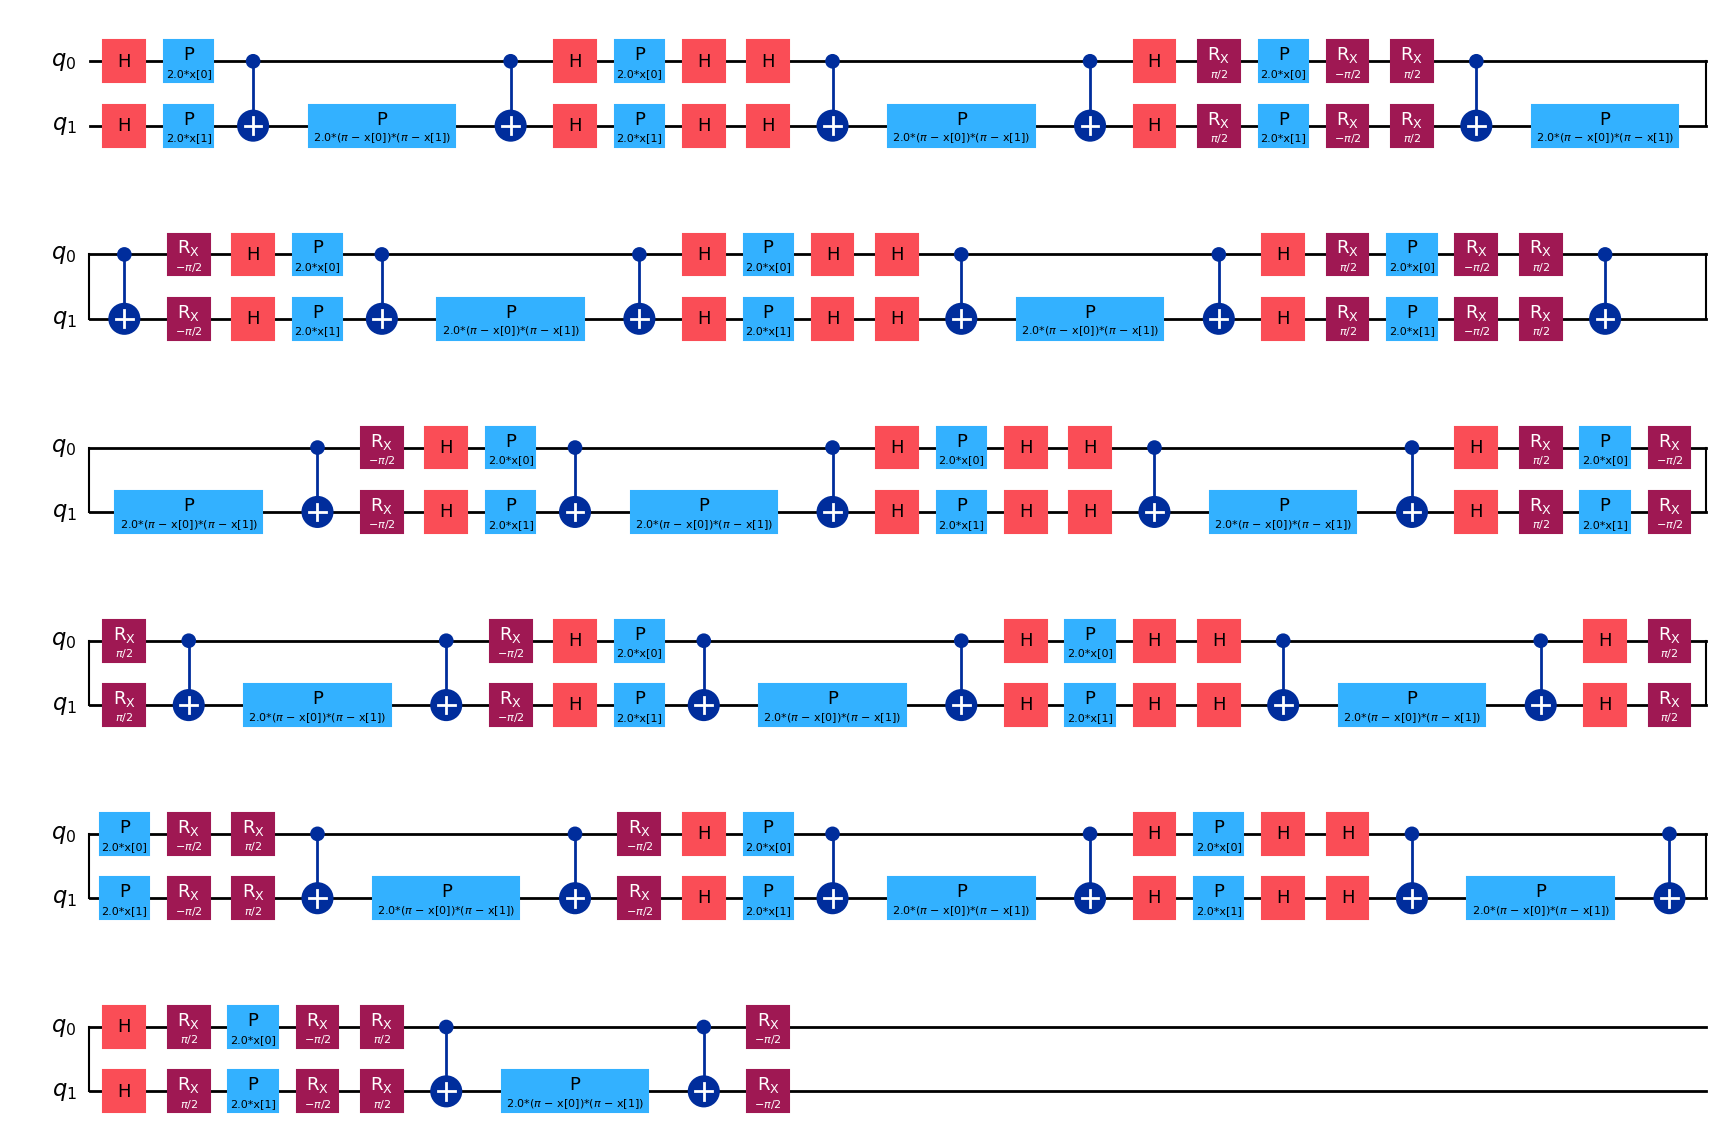

In [3]:
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.visualization import circuit_drawer


dataset_feature_map = PauliFeatureMap(feature_dimension=feature_dimentions, reps=5, paulis=['Z', 'ZZ', 'X', 'XX', 'Y', 'YY'])

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

data_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=dataset_feature_map)

circuit_drawer(dataset_feature_map.decompose(), output='mpl')

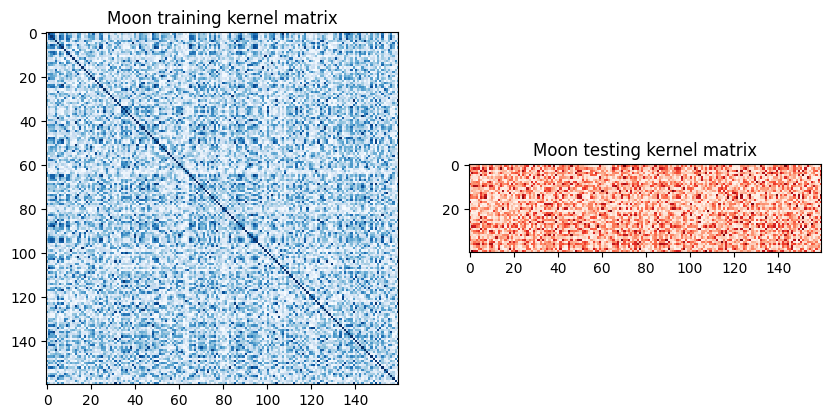

In [4]:
import matplotlib.pyplot as plt
import numpy as np


moon_matrix_train = data_kernel.evaluate(x_vec=X_train)
moon_matrix_test = data_kernel.evaluate(x_vec=X_test, y_vec=X_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(moon_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Moon training kernel matrix")

axs[1].imshow(np.asmatrix(moon_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Moon testing kernel matrix")
plt.show()


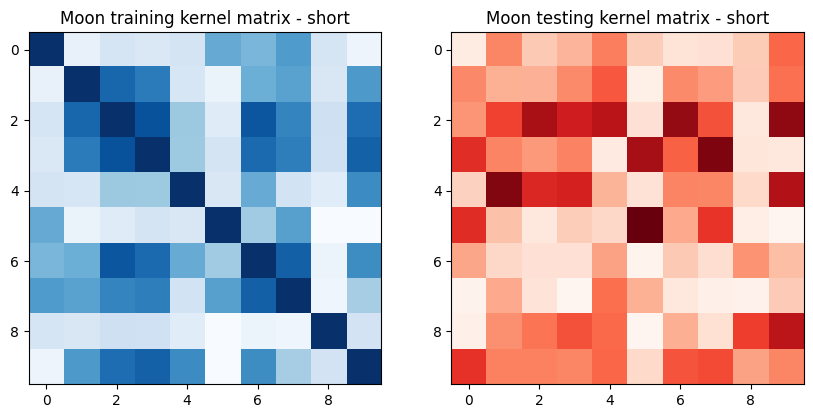

In [5]:
moon_matrix_short = data_kernel.evaluate(x_vec=X_train[:10])
moon_matrix_test_short = data_kernel.evaluate(x_vec=X_test[:10], y_vec=X_train[:10])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(moon_matrix_short), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Moon training kernel matrix - short")

axs[1].imshow(np.asmatrix(moon_matrix_test_short), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Moon testing kernel matrix - short")
plt.show()

In [6]:
from sklearn.svm import SVC

moon_svc = SVC(kernel="precomputed")

moon_svc.fit(moon_matrix_train, y_train)

moon_score_precomputed_kernel = moon_svc.score(moon_matrix_test, y_test)

print(f"Precomputed kernel classification test score: {moon_score_precomputed_kernel}")

Precomputed kernel classification test score: 0.85


In [7]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=data_kernel)

qsvc.fit(X_train, y_train)

qsvc_score = qsvc.score(X_test, y_test)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.85


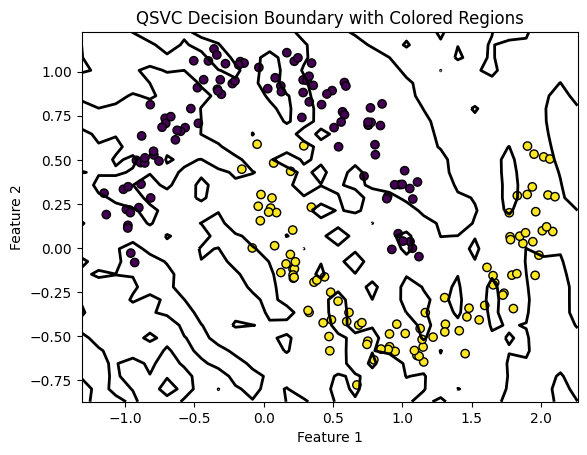

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = qsvc.decision_function(xy).reshape(XX.shape)


ax.contour(XX, YY, Z, colors='k', levels=[0], linewidths=2)
plt.title('QSVC Decision Boundary with Colored Regions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

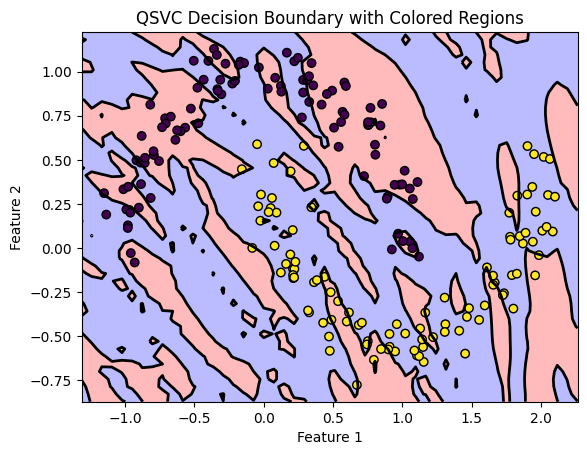

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
# Plotting decision boundaries
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()


# Create a grid
xx = np.linspace(xlim[0], xlim[1], 50)
yy = np.linspace(ylim[0], ylim[1], 50)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = qsvc.decision_function(xy).reshape(XX.shape)

# Plot the colored areas
ax.contourf(XX, YY, Z, levels=[Z.min(), 0, Z.max()], colors=['#FFAAAA', '#AAAAFF'], alpha=0.8)

# Plot only the decision boundary line
ax.contour(XX, YY, Z, colors='k', levels=[0], linewidths=2)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')

plt.title('QSVC Decision Boundary with Colored Regions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()